In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torchvision
import random

from ntu_dataset import NTUDataset
import preprocess.augmentations as augmentations
from preprocess.augmentations import Normalize3D
from base_dataset import BaseDataset

/home/yas50454/miniconda3/envs/torch_1_131/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '


In [2]:
action_classes = [
    'drink water', 'eat meal/snack', 'brushing teeth', 'brushing hair', 'drop', 'pickup', 'throw', 'sitting down',
    'standing up (from sitting position)', 'clapping', 'reading', 'writing', 'tear up paper', 'wear jacket',
    'take off jacket', 'wear a shoe', 'take off a shoe', 'wear on glasses', 'take off glasses', 'put on a hat/cap',
    'take off a hat/cap', 'cheer up', 'hand waving', 'kicking something', 'reach into pocket', 'hopping (one foot jumping)',
    'jump up', 'make a phone call/answer phone', 'playing with phone/tablet', 'typing on a keyboard',
    'pointing to something with finger', 'taking a selfie', 'check time (from watch)', 'rub two hands together',
    'nod head/bow', 'shake head', 'wipe face', 'salute', 'put palms together', 'cross hands in front',
    'sneeze/cough', 'staggering', 'falling', 'touch head (headache)', 'touch chest (stomachache/heart pain)',
    'touch back (backache)', 'touch neck (neckache)', 'nausea or vomiting condition', 'use a fan (with hand or paper)/feeling warm',
    'punching/slapping other person', 'kicking other person', 'pushing other person', 'pat on back of other person',
    'point finger at the other person', 'hugging other person', 'giving something to other person', 'touch other person\'s pocket',
    'handshaking', 'walking towards each other', 'walking apart from each other'
]

idx_to_class = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
    23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
    44, 45, 46, 47, 48, 49, 50,  51, 52, 53, 54, 55, 56, 57, 58, 59, 60
]

ntu_pairs = [(0, 1), (1, 20), (2, 20), (3, 2), (4, 20), (5, 4),
        (6, 5), (7, 6), (8, 20), (9, 8), (10, 9), (11, 10),
        (12, 0), (13, 12), (14, 13), (15, 14), (16, 0), (17, 16),
        (18, 17), (19, 18), (21, 22), (20, 20), (22, 7), (23, 24), (24, 11)]


In [3]:
ann_file = '/home/yas50454/datasets/NTU_Data/NTU_60/ntu60_3danno.pkl'
normalizer = augmentations.Normalize3D()
pipeline = torchvision.transforms.Compose([normalizer])
noiser = augmentations.RandomAdditiveNoise(dist='NORMAL', prob=0.5, std=0.01)
augmentation = torchvision.transforms.Compose([noiser])
dataset = NTUDataset(ann_file, pipeline=None, split='xsub_train', num_classes=60, multi_class=True, augmentation=None)
    

In [4]:
print(f"Dataset size: {len(dataset)}")
print(dataset[0].keys())
tmp = dataset[150]

Dataset size: 40091
dict_keys(['frame_dir', 'label', 'keypoint', 'total_frames', 'start_index', 'input'])


In [5]:
tmp = dataset[350]
print(f"tmp['frame_dir']={tmp['frame_dir']}\ntmp['label']={tmp['label'].shape}\ntmp['keypoint']={tmp['keypoint'].shape}\ntmp['total_frames']={tmp['total_frames']}\ntmp['start_index']={tmp['start_index']}\ntmp['input']={tmp['input'].shape}\n")


tmp['frame_dir']=S001C001P004R002A051
tmp['label']=torch.Size([60])
tmp['keypoint']=torch.Size([2, 55, 25, 3])
tmp['total_frames']=55
tmp['start_index']=0
tmp['input']=torch.Size([2, 55, 25, 3])



In [6]:
lengths = []
split_length = 500
for i in range(split_length):
    total_frame= dataset[i]['total_frames']
    lengths.append(total_frame)
max_total_frame = max(lengths)
print(f"Max total frame length: {max_total_frame}")

Max total frame length: 237


In [13]:
from torch.utils.data import DataLoader
import random
torch.cuda.manual_seed_all(1)
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)
batch_size = 5
num_worker = 8

ntu_train_dataloader = DataLoader(
                dataset=dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=num_worker,
                drop_last=True,
                collate_fn=dataset.collate_fn)

In [8]:
print(f"batch['keypoint'].shape: {batch['keypoint'].shape}")
print(f"batch['input'].shape: {batch['input'].shape}")

batch['keypoint'].shape: torch.Size([5, 158, 75])
batch['input'].shape: torch.Size([5, 158, 75])


In [84]:
def plot_tensor_skeleton(tensor: torch.Tensor, set_frame: int=None, all_subjects: bool=False):
    """
    Take as input a tensor of shape (C, T, V, M)
    """
    ntu_pairs = [(0, 1), (1, 20), (2, 20), (3, 2), (4, 20), (5, 4),
            (6, 5), (7, 6), (8, 20), (9, 8), (10, 9), (11, 10),
            (12, 0), (13, 12), (14, 13), (15, 14), (16, 0), (17, 16),
            (18, 17), (19, 18), (21, 22), (20, 20), (22, 7), (23, 24), (24, 11)]
    print(tensor.shape)
    
    if set_frame is not None:
        if set_frame > tensor.shape[1]:
            raise ValueError(f"Frame value to high, total frame {tensor.shape[1]}")
        else:
            random_frame_idx = set_frame
    else:
        random_frame_idx = random.choice(range(tensor.shape[1]))

    tensor_reshaped = tensor.permute(3, 1, 2, 0)

    if all_subjects:
        x_keypoint_0 = tensor_reshaped[0][random_frame_idx][:,0] 
        y_keypoint_0 = tensor_reshaped[0][random_frame_idx][:,1]

        x_keypoint_1 = tensor_reshaped[1][random_frame_idx][:,0] 
        y_keypoint_1 = tensor_reshaped[1][random_frame_idx][:,1]

        plt.figure(figsize=(4,6))
        for i,j in ntu_pairs:
            plt.plot([x_keypoint_0[i], x_keypoint_0[j]], [y_keypoint_0[i],y_keypoint_0[j]], c='b', marker='o')
            plt.plot([x_keypoint_1[i], x_keypoint_1[j]], [y_keypoint_1[i],y_keypoint_1[j]], c='r', marker='o')
        
        plt.xlim([np.amin(tensor_reshaped[:,:,:,0].numpy()), np.amax(tensor_reshaped[:,:,:,0].numpy())])
        plt.ylim([np.amin(tensor_reshaped[:,:,:,1].numpy()), np.amax(tensor_reshaped[:,:,:,1].numpy())])

        title = f"Sample total lengh: {tensor_reshaped.shape[1]} frame: {random_frame_idx}"
        plt.title(title)
    else:
        x_keypoint = tensor_reshaped[0][random_frame_idx][:,0] 
        y_keypoint = tensor_reshaped[0][random_frame_idx][:,1]
        plt.figure(figsize=(5,8))
        for i,j in ntu_pairs:
            plt.plot([x_keypoint[i], x_keypoint[j]], [y_keypoint[i],y_keypoint[j]], c='b', marker='o')
        
        plt.xlim([np.amin(tensor_reshaped[0,:,:,0].numpy()), np.amax(tensor_reshaped[0,:,:,0].numpy())])
        plt.ylim([np.amin(tensor_reshaped[0,:,:,1].numpy()), np.amax(tensor_reshaped[0,:,:,1].numpy())])

        title = f"Sample total lengh: {tensor_reshaped.shape[1]} frame: {random_frame_idx}"
        plt.title(title)
        

In [8]:
from typing import List  
def display_random_skeletons(dataset: torch.utils.data.Dataset,
                          classes: List[str],
                          n: int=5,
                          keypoint: str='keypoint',
                          display_shape: bool=True,
                          seed: int=None):
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    if seed:
      random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)
    # colors = ['g', 'g', 'g', 'g', 'b', 'b', 'b', 'b', 'r', 'r', 'r', 'r', 'c', 'c', 'c', 'c', 'm', 'm',
    #                       'm', 'm', 'g', 'b', 'b', 'r', 'r']
    ntu_pairs = [(0, 1), (1, 20), (2, 20), (3, 2), (4, 20), (5, 4),
        (6, 5), (7, 6), (8, 20), (9, 8), (10, 9), (11, 10),
        (12, 0), (13, 12), (14, 13), (15, 14), (16, 0), (17, 16),
        (18, 17), (19, 18), (21, 22), (20, 20), (22, 7), (23, 24), (24, 11)]
    
    plt.figure(figsize=(32,8))
    for i, targ_sample in enumerate(random_samples_idx):

        random_frame_idx = random.choice(range(dataset[targ_sample][keypoint].shape[1]))
        targ_keypoint, targ_label = dataset[targ_sample][keypoint], dataset[targ_sample]['label']
        num_subject = dataset[targ_sample][keypoint].shape[0]
        action_label = action_classes[np.argmax(dataset[targ_sample]['label'])]

        if num_subject == 2:
            x_0 = dataset[targ_sample][keypoint][0][random_frame_idx][:,0]
            y_0 = dataset[targ_sample][keypoint][0][random_frame_idx][:,1]

            x_1 = dataset[targ_sample][keypoint][1][random_frame_idx][:,0]
            y_1 = dataset[targ_sample][keypoint][1][random_frame_idx][:,1]

            action_label = action_classes[np.argmax(dataset[targ_sample]['label'])]
            plt.subplot(1,n,i+1)
            #plt.xlim(-0.4,0.8)
            for i,j in ntu_pairs:
                plt.plot([x_0[i], x_0[j]], [y_0[i], y_0[j]], color='r', marker='o')
                plt.plot([x_1[i], x_1[j]], [y_1[i], y_1[j]], color='b', marker='o')
            plt.xlim([np.amin(dataset[targ_sample][keypoint][:,:,:,0].numpy()), np.amax(dataset[targ_sample][keypoint][:,:,:,0].numpy())])
            plt.ylim([np.amin(dataset[targ_sample][keypoint][:,:,:,1].numpy()), np.amax(dataset[targ_sample][keypoint][:,:,:,1].numpy())])
              
            if classes:
                title = f"Class: {action_label}"
                if display_shape:
                    title = title + f"\nSample number: {targ_sample}, total length: {dataset[targ_sample][keypoint].shape[1]} frame: {random_frame_idx}"

            plt.title(title)

        else:
            x = dataset[targ_sample][keypoint][0][random_frame_idx][:,0]
            y = dataset[targ_sample][keypoint][0][random_frame_idx][:,1]

            action_label = action_classes[np.argmax(dataset[targ_sample]['label'])]
            plt.subplot(1,n,i+1)

            for i,j in ntu_pairs:
                plt.plot([x[i], x[j]], [y[i], y[j]], color='r', marker='o')
            plt.xlim([np.amin(dataset[targ_sample][keypoint][:,:,:,0].numpy()), np.amax(dataset[targ_sample][keypoint][:,:,:,0].numpy())])
            plt.ylim([np.amin(dataset[targ_sample][keypoint][:,:,:,1].numpy()), np.amax(dataset[targ_sample][keypoint][:,:,:,1].numpy())])
            
                    
            if classes:
                title = f"Class: {action_label}"
                if display_shape:
                    title = title + f"\nSample number: {targ_sample}, total length: {dataset[targ_sample][keypoint].shape[1]} frame: {random_frame_idx}"

            plt.title(title)


In [9]:
from typing import List  
def display_compare_skeletons(dataset: torch.utils.data.Dataset,
                          classes: List[str],
                          n: int=10,
                          display_shape: bool=True,
                          seed: int=None):
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    if seed:
      random.seed(seed)

    ntu_pairs = [(0, 1), (1, 20), (2, 20), (3, 2), (4, 20), (5, 4),
            (6, 5), (7, 6), (8, 20), (9, 8), (10, 9), (11, 10),
            (12, 0), (13, 12), (14, 13), (15, 14), (16, 0), (17, 16),
            (18, 17), (19, 18), (21, 22), (20, 20), (22, 7), (23, 24), (24, 11)]
    
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(32,8))
    for i, targ_sample in enumerate(random_samples_idx):

        random_frame_idx = random.choice(range(dataset[targ_sample]['keypoint'].shape[0]))
        targ_keypoint, targ_label = dataset[targ_sample]['keypoint'], dataset[targ_sample]['label']
        targ_input_keypoint = dataset[targ_sample]['input']


        x_keypoint = dataset[targ_sample]['keypoint'][random_frame_idx][:,0]
        y_keypoint = dataset[targ_sample]['keypoint'][random_frame_idx][:,1]

        x_input = dataset[targ_sample]['input'][random_frame_idx][:,0]
        y_input = dataset[targ_sample]['input'][random_frame_idx][:,1]

        action_label = action_classes[np.argmax(dataset[targ_sample]['label'])]
        plt.subplot(1,n,i+1)
        for i,j in ntu_pairs:
            plt.plot([x_keypoint[i], x_keypoint[j]], [y_keypoint[i],y_keypoint[j]], c='b', marker='o')
            plt.plot([x_input[i], x_input[j]], [y_input[i], y_input[j]], c='r', marker='o')

        plt.xlim([np.amin(dataset[targ_sample]['input'][:,:,0].numpy()), np.amax(dataset[targ_sample]['input'][:,:,0].numpy())])
        plt.ylim([np.amin(dataset[targ_sample]['input'][:,:,1].numpy()), np.amax(dataset[targ_sample]['input'][:,:,1].numpy())])
        
       
        # plt.axis(False)
        if classes:
            title = f"Class: {action_label}"
            if display_shape:
                title = title + f"\nSample number: {targ_sample}, total lengh: {dataset[targ_sample]['keypoint'].shape[0]} frame: {random_frame_idx}"

        plt.title(title)

In [51]:
dataset[350]['keypoint'].shape

torch.Size([2, 55, 25, 3])

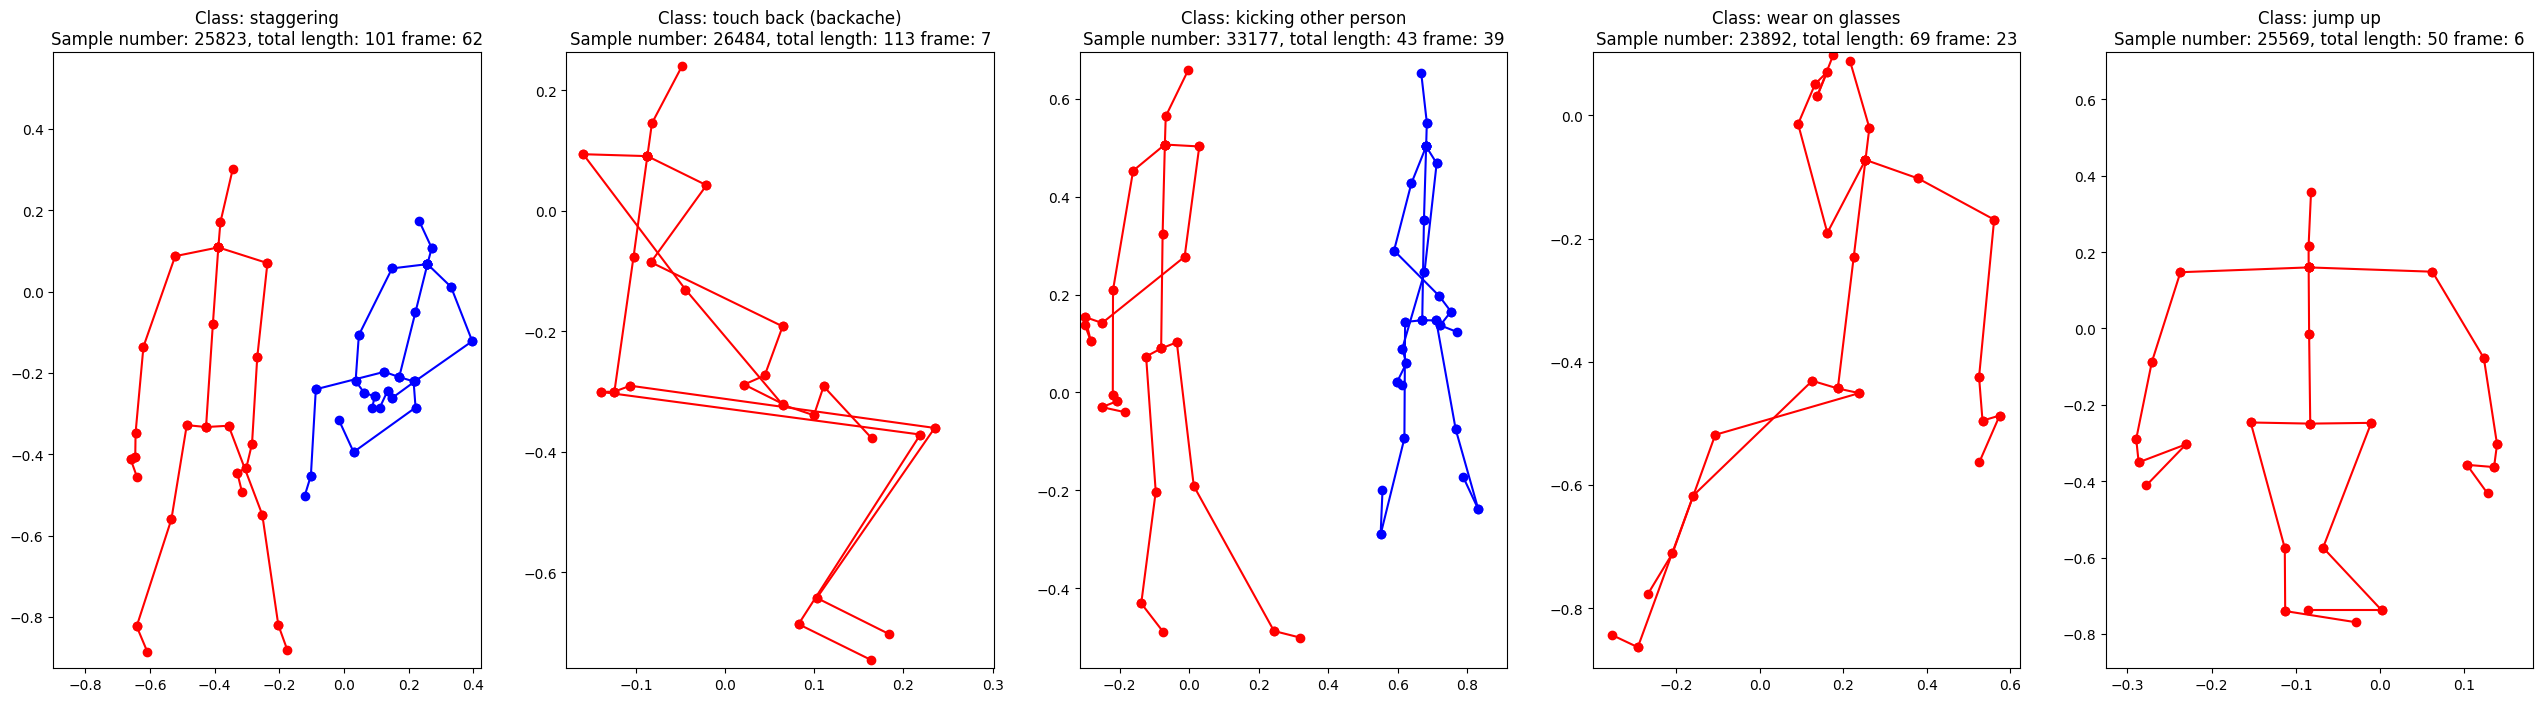

In [11]:
display_random_skeletons(dataset=dataset,
                         classes=action_classes,
                         n=5,
                         keypoint='keypoint',
                         seed=None)

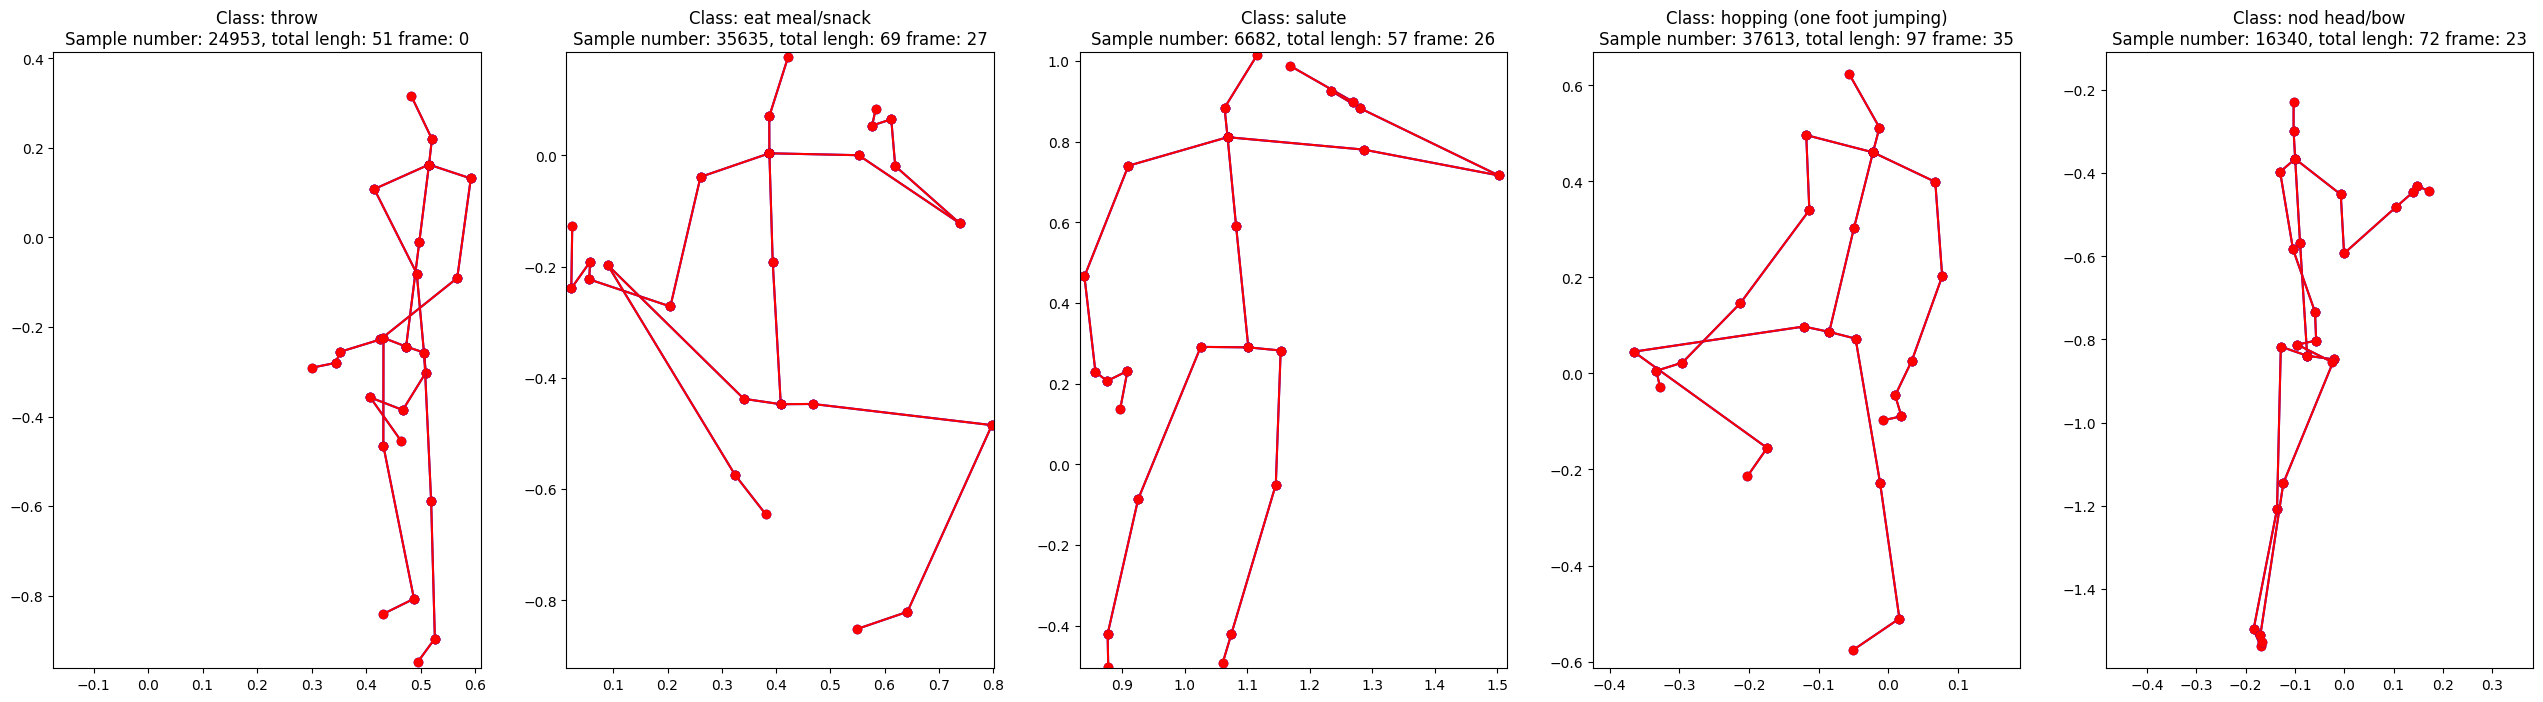

In [13]:
display_compare_skeletons(dataset=dataset,
                         classes=action_classes,
                         n=5,
                         seed=None)

In [18]:
def add_padding(tensor: torch.Tensor, padding):
    """
    Adds padding to a PyTorch tensor.
    
    Args:
        tensor (torch.Tensor): A PyTorch tensor of type float.
        padding (int): The value of padding to add.
        
    Returns:
        torch.Tensor: The processed tensor with padding added.
    """
    # Get the shape of the input tensor
    shape = tensor.shape
    tensor_reshaped = tensor.reshape(shape[0], shape[1]*shape[2])
    
    # Create a new tensor with the shape of the input tensor
    padded_tensor = torch.zeros((shape[0], (shape[1]*shape[2]) + padding))
    
    # Copy the input tensor into the padded tensor
    padded_tensor[:, :(shape[1]*shape[2])] = tensor_reshaped
    
    return padded_tensor


In [14]:
def feeder_tensor_reshape(tensor: torch.Tensor):
    tmp_reshaped = tensor.permute(3,1,2,0)
    return tmp_reshaped

In [15]:
ntu_sample = dataset[10]
print(ntu_sample['keypoint'].shape)
feeder_ntu_sample = feeder_tensor_reshape(ntu_sample['keypoint'])
feeder_ntu_sample.shape

torch.Size([1, 82, 25, 3])


torch.Size([3, 82, 25, 1])

torch.Size([3, 55, 25, 2])


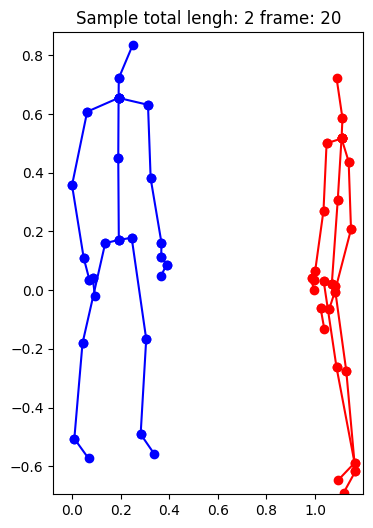

In [20]:
plot_tensor_skeleton(tmp['keypoint'].permute(3,1,2,0), set_frame=20, all_subjects=True)

In [21]:
def crop_frames(tensor: torch.Tensor, window_size):
    C, T, V, M = tensor.shape
    
    if T < window_size:
        # If the window size is longer than the actual frame length,
        # we pad the tensor with zeros along the T dimension
        padded_tensor = torch.zeros((C, window_size, V, M))
        padded_tensor[:, :T, :, :] = tensor
        return padded_tensor
    
    # If the crop size is shorter, we don't need to pad the tensor
    tensor_permuted = tensor.permute(3,2,0,1)
    tensor_cropped = tensor_permuted[:,:,:,:window_size]
    M, V, C, T = tensor_cropped.shape
    cropped_tensor = tensor_cropped.permute(2,3,1,0)
    return cropped_tensor

In [22]:
feeder_ntu_sample_cropped = crop_frames(feeder_ntu_sample, 120)
feeder_ntu_sample_cropped.shape

torch.Size([3, 120, 25, 1])

torch.Size([3, 120, 25, 1])


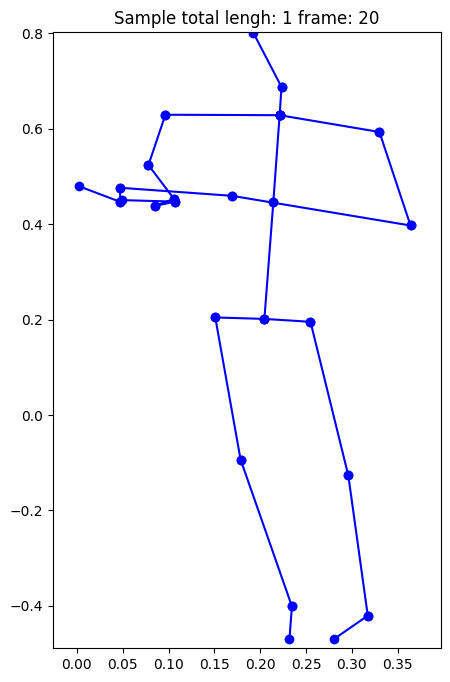

In [28]:
plot_tensor_skeleton(feeder_ntu_sample_cropped, set_frame=20, all_subjects=False)

In [89]:
import sys
import os

notebook_path = "/home/yas50454/repos/STTFormer/tafar-experimental_david-datasets/datasets/preprocess/ntu_preprocess_pytorch.py"
# Add parent directory to path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(notebook_path), '..', '..', '..')))

from model.sttformer import Model
output_device = 1 # GPU device

config = [[64,  64,  16], [64,  64,  16], 
           [64,  128, 32], [128, 128, 32],
           [128, 256, 64], [256, 256, 64], 
           [256, 256, 64], [256, 256, 64]]

sttformer_model = Model(len_parts=6,
              num_frames=120,
              num_joints=25,
              num_classes=60,
              num_heads=3,
              num_channels=3,
              num_persons=2,
              kernel_size=[3,5],
              use_pes=True,
              config=config).cuda(output_device)

sttformer_model

Model(
  (input_map): Sequential(
    (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (blocks): ModuleList(
    (0): STA_Block(
      (pes): Pos_Embed()
      (to_qkvs): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1))
      (out_nets): Sequential(
        (0): Conv2d(192, 64, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (ff_net): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (out_nett): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (tan): Tanh()
      (

In [30]:
feeder_ntu_sample_cropped = feeder_ntu_sample_cropped.unsqueeze(0)
feeder_ntu_sample_cropped.shape

torch.Size([1, 3, 120, 25, 1])

In [31]:
feeder_ntu_sample_cropped = feeder_ntu_sample_cropped.cuda(output_device)

In [32]:
# Forward pass
pred = sttformer_model(feeder_ntu_sample_cropped)

In [33]:
torch.argmax(pred, dim=1)

tensor([40], device='cuda:1')

In [108]:
class NTU2Feeder:
    """
    Class for preprocessing NTU Dataset as STTFormer feeder format
    """
    def feeder_tensor_reshape(self, tensor: torch.Tensor):
        # tmp_padded = add_padding(tensor, 75) ## ERROR not working well
        # tensor = tensor.unsqueeze(0)
        tmp_reshaped = tensor.permute(3,1,2,0)
        return tmp_reshaped
    
    @staticmethod
    def plot_tensor_skeleton(tensor: torch.Tensor, set_frame: int=None, all_subjects: bool=False):
        """
        Take as input a tensor of shape (C, T, V, M)
        """
        ntu_pairs = [(0, 1), (1, 20), (2, 20), (3, 2), (4, 20), (5, 4),
                (6, 5), (7, 6), (8, 20), (9, 8), (10, 9), (11, 10),
                (12, 0), (13, 12), (14, 13), (15, 14), (16, 0), (17, 16),
                (18, 17), (19, 18), (21, 22), (20, 20), (22, 7), (23, 24), (24, 11)]
        print(tensor.shape)
        
        if set_frame is not None:
            if set_frame > tensor.shape[1]:
                raise ValueError(f"Frame value to high, total frame {tensor.shape[1]}")
            else:
                random_frame_idx = set_frame
        else:
            random_frame_idx = random.choice(range(tensor.shape[1]))

        tensor_reshaped = tensor.permute(3, 1, 2, 0)

        if all_subjects:
            x_keypoint_0 = tensor_reshaped[0][random_frame_idx][:,0] 
            y_keypoint_0 = tensor_reshaped[0][random_frame_idx][:,1]

            x_keypoint_1 = tensor_reshaped[1][random_frame_idx][:,0] 
            y_keypoint_1 = tensor_reshaped[1][random_frame_idx][:,1]

            plt.figure(figsize=(4,6))
            for i,j in ntu_pairs:
                plt.plot([x_keypoint_0[i], x_keypoint_0[j]], [y_keypoint_0[i],y_keypoint_0[j]], c='b', marker='o')
                plt.plot([x_keypoint_1[i], x_keypoint_1[j]], [y_keypoint_1[i],y_keypoint_1[j]], c='r', marker='o')
            
            plt.xlim([np.amin(tensor_reshaped[:,:,:,0].numpy()), np.amax(tensor_reshaped[:,:,:,0].numpy())])
            plt.ylim([np.amin(tensor_reshaped[:,:,:,1].numpy()), np.amax(tensor_reshaped[:,:,:,1].numpy())])

            title = f"Sample total lengh: {tensor_reshaped.shape[1]} frame: {random_frame_idx}"
            plt.title(title)
        else:
            x_keypoint = tensor_reshaped[0][random_frame_idx][:,0] 
            y_keypoint = tensor_reshaped[0][random_frame_idx][:,1]
            plt.figure(figsize=(5,8))
            for i,j in ntu_pairs:
                plt.plot([x_keypoint[i], x_keypoint[j]], [y_keypoint[i],y_keypoint[j]], c='b', marker='o')
            
            plt.xlim([np.amin(tensor_reshaped[0,:,:,0].numpy()), np.amax(tensor_reshaped[0,:,:,0].numpy())])
            plt.ylim([np.amin(tensor_reshaped[0,:,:,1].numpy()), np.amax(tensor_reshaped[0,:,:,1].numpy())])

            title = f"Sample total lengh: {tensor_reshaped.shape[1]} frame: {random_frame_idx}"
            plt.title(title)
            
    def crop_frames(self, tensor: torch.Tensor, window_size):
        C, T, V, M = tensor.shape
        if M == 2:
            if T < window_size:
                # If the window size is longer than the actual frame length,
                # we pad the tensor with zeros along the T dimension
                padded_tensor = torch.zeros((C, window_size, V, M))
                padded_tensor[:, :T, :, :] = tensor
                return padded_tensor
            
            # If the crop size is shorter, we don't need to pad the tensor
            tensor_permuted = tensor.permute(3,2,0,1)
            tensor_cropped = tensor_permuted[:,:,:,:window_size]
            M, V, C, T = tensor_cropped.shape
            cropped_tensor = tensor_cropped.permute(2,3,1,0)
            return cropped_tensor
        if T < window_size:
            # If the window size is longer than the actual frame length,
            # we pad the tensor with zeros along the T dimension
            padded_tensor = torch.zeros((C, window_size, V, M))
            padded_tensor[:, :T, :, :] = tensor
            padded_tensor = padded_tensor.permute(3,1,2,0)
            padded_tensor_added = torch.zeros((2, window_size, V, C))
            padded_tensor_added[:1,:,:,:] = padded_tensor
            padded_tensor_added = padded_tensor_added.permute(3,1,2,0)
            return padded_tensor_added
        
        tensor_permuted = tensor.permute(3,2,0,1)
        tensor_cropped = tensor_permuted[:,:,:,:window_size]
        padded_tensor = tensor_cropped.permute(0,3,1,2)
        M, T, V, C = padded_tensor.shape
        padded_tensor_added = torch.zeros((2, T, V, C))
        padded_tensor_added[:1,:,:,:] = padded_tensor
        padded_tensor_added = padded_tensor_added.permute(3,1,2,0)
        return padded_tensor_added
    
    def __init__(self, window_size: int=120):
        self.window_size = window_size

    def __call__(self, dataset_item):
        skeleton = dataset_item['keypoint']
        tensor = torch.tensor(skeleton)
        tensor = self.feeder_tensor_reshape(tensor)
        tensor_cropped = self.crop_frames(tensor, self.window_size)
        dataset_item['keypoint'] = tensor_cropped.numpy()
        dataset_item['input'] = tensor_cropped.numpy() #copy keypoint content to input (to solve problem of shape for Dataloader)

        return dataset_item
                

In [109]:
ann_file = '/home/yas50454/datasets/NTU_Data/NTU_60/ntu60_3danno.pkl'
ntu2feeder = NTU2Feeder(window_size=120)
pipeline = torchvision.transforms.Compose([ntu2feeder])
ntu_feeder_dataset = NTUDataset(ann_file, pipeline=pipeline, split='xsub_train', num_classes=60, multi_class=True, augmentation=None)

In [113]:
ntu_feeder_dataset[1]['keypoint'].shape

torch.Size([2, 120, 25, 3])

torch.Size([2, 120, 25, 3])


/home/yas50454/miniconda3/envs/torch_1_131/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


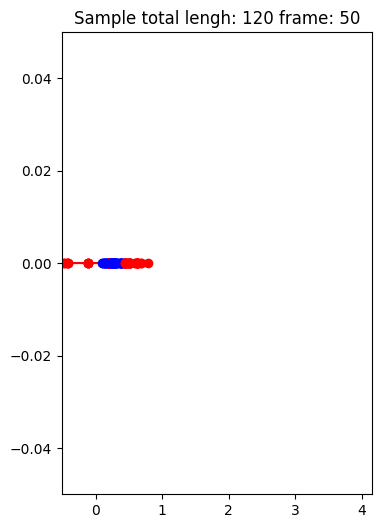

In [111]:
ntu_feeder_dataset_sample = ntu_feeder_dataset[1]
NTU2Feeder.plot_tensor_skeleton(ntu_feeder_dataset_sample['keypoint'], set_frame=50, all_subjects=True)

In [102]:
from torch.utils.data import DataLoader

torch.cuda.manual_seed_all(1)
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)
batch_size = 64
num_worker = 8

ntu_feeder_train_dataloader = DataLoader(
                dataset=ntu_feeder_dataset,
                batch_size=batch_size,
                shuffle=False,
                num_workers=num_worker,
                drop_last=True)

In [107]:
ntu_feeder_train_batch = next(iter(ntu_feeder_train_dataloader))
ntu_feeder_train_batch['input'].shape

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/yas50454/miniconda3/envs/torch_1_131/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/yas50454/miniconda3/envs/torch_1_131/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 61, in fetch
    return self.collate_fn(data)
  File "/home/yas50454/miniconda3/envs/torch_1_131/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/yas50454/miniconda3/envs/torch_1_131/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 128, in collate
    return elem_type({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
  File "/home/yas50454/miniconda3/envs/torch_1_131/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 128, in <dictcomp>
    return elem_type({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
  File "/home/yas50454/miniconda3/envs/torch_1_131/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 120, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/home/yas50454/miniconda3/envs/torch_1_131/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 163, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [2, 120, 25, 3] at entry 0 and [3, 120, 25, 2] at entry 49


In [103]:
frame_dir, y, X, _ , _, _ = ntu_feeder_train_batch.values()

In [105]:
X.shape

torch.Size([5, 2, 120, 25, 3])

In [104]:
sttformer_model(X.cuda(output_device)).shape

RuntimeError: Given groups=1, weight of size [64, 3, 1, 1], expected input[15, 2, 20, 150] to have 3 channels, but got 2 channels instead

In [81]:
ntu_feeder_dataset_sample.pop('keypoint').shape

KeyError: 'keypoint'

In [103]:
ntu_feeder_dataset_batch = ntu_feeder_dataset_sample['keypoint'].unsqueeze(0)
ntu_feeder_dataset_batch.shape

torch.Size([1, 3, 120, 25, 1])

In [107]:
b_pose_noisy = [ntu_feeder_dataset[0]['keypoint'], ntu_feeder_dataset[1]['keypoint']]
b_pose_noisy[0].shape

torch.Size([3, 120, 25, 1])

In [135]:
import pdb

from common import utils
mask_pad_value = 1

b_pose_noisy = [ntu_feeder_dataset[0]['keypoint'], ntu_feeder_dataset[1]['keypoint']]
b_pose_noisy_zero, mask_zero = utils.pad_sequence(
            b_pose_noisy, padding_value=0, mask_padding_value=mask_pad_value,
            return_mask=True,
        )

In [134]:
b_pose_noisy_zero.shape

torch.Size([2, 3, 120, 25, 1])

In [131]:
mask

tensor([[0., 0., 0.],
        [0., 0., 0.]])